# 코드의 빈공간을 채워서 vae와 ae를 구현하고, 시각화 시켜보기



In [ ]:
# ## 사전 준비
# 필요한 라이브러리를 임포트하고 하이퍼파라미터를 설정합니다.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [ ]:
# 하이퍼파라미터 설정
bs = 512        # 배치 크기
n_epoch = 10     # 에포크 수
z_dim = 32       # 잠재 공간 차원
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 장치 설정

# 랜덤 시드 설정 (재현성 확보)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

In [ ]:
# ## MNIST 데이터셋 로드
# MNIST 데이터셋을 다운로드하고 학습 및 테스트를 위한 데이터 로더를 준비합니다.

# MNIST 데이터셋 다운로드 및 변환
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root='./mnist_data/',
    train=True,
    transform=transform,
    download=True
)
test_dataset = datasets.MNIST(
    root='./mnist_data/',
    train=False,
    transform=transform,
    download=False
)

# 데이터 로더 설정
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=bs,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=bs,
    shuffle=False
)

In [ ]:
# ## Autoencoder (AE) 모델 정의

class AE(nn.Module):


In [ ]:

# ## Variational Autoencoder (VAE) 모델 정의

class VAE(nn.Module):


In [ ]:
# ## 모델 및 옵티마이저 초기화
# AE와 VAE 모델을 초기화하고, GPU가 사용 가능하면 GPU로 이동시킵니다. 그리고 옵티마이저를 설정합니다.

# 모델 초기화
ae = AE().to(device)
vae = VAE(z_dim=z_dim).to(device)

print("Autoencoder (AE) 구조:")
print(ae)
print("\nVariational Autoencoder (VAE) 구조:")
print(vae)

# 옵티마이저 설정
ae_optimizer = optim.Adam(ae.parameters(), lr=1e-3)
vae_optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [ ]:
# ## 손실 함수 정의

# AE의 손실 함수:
def ae_loss_function(recon_x, x):

# VAE의 손실 함수:
def vae_loss_function(recon_x, x, mu, log_var):

In [ ]:
# ## 학습 함수 정의


def train_ae(epoch):


def train_vae(epoch):


In [ ]:

# ## 테스트 함수 정의

def test_ae():
    ae.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon = ae(data.view(-1, 784))
            test_loss += ae_loss_function(recon, data).item()

    test_loss /= len(test_loader.dataset)
    print(f'====> AE 테스트 세트 손실: {test_loss:.4f}')

def test_vae():
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, log_var = vae(data)
            test_loss += vae_loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print(f'====> VAE 테스트 세트 손실: {test_loss:.4f}')

In [ ]:
# ## 학습 루프 실행

for epoch in range(1, n_epoch + 1):
    print(f'\n=== 에포크 {epoch} ===')
    train_ae(epoch)
    test_ae()
    train_vae(epoch)
    test_vae()

In [ ]:
# ## 재구성 이미지 시각화
# 테스트 데이터셋에서 일부 이미지를 AE와 VAE로 재구성한 결과를 비교하여 시각화합니다.

def visualize_reconstructions(model, data, title, is_vae=False):
    model.eval()
    with torch.no_grad():
        if is_vae:
            recon, mu, log_var = model(data.view(-1, 784).to(device))
        else:
            recon = model(data.view(-1, 784).to(device))
    recon = recon.cpu()

    data = data.cpu()
    recon = recon.view(-1, 1, 28, 28)
    comparison = torch.cat([data[:8], recon[:8]])

    grid = make_grid(comparison, nrow=8)
    plt.figure(figsize=(16,4))
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

# 테스트 데이터에서 첫 번째 배치 가져오기
test_iter = iter(test_loader)
test_data, _ = next(test_iter)  # 수정된 부분

# AE 재구성 이미지 시각화
visualize_reconstructions(ae, test_data, 'Autoencoder (AE)')

# VAE 재구성 이미지 시각화
visualize_reconstructions(vae, test_data, 'Variational Autoencoder (VAE)', is_vae=True)

In [ ]:
# ## VAE 샘플링 시각화
# VAE의 잠재 공간에서 샘플을 생성하여 이미지를 시각화합니다.

with torch.no_grad():
    z = torch.randn(64, z_dim).to(device)
    sample = vae.decoder_model(z).cpu()

sample = sample.view(64, 1, 28, 28)
grid = make_grid(sample, nrow=8)
plt.figure(figsize=(16,16))
plt.title('VAE image')
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.show()

Autoencoder (AE) 구조:
AE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

Variational Autoencoder (VAE) 구조:
VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=32, bias=True)
  (fc32): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

=== 에포크 1 ===
AE 학습 에포크: 1 [0/60000 (0%)]	손실: 543.333069
AE 학습 에포크: 1 [51200/60000 (85%)]	손실: 179.485718
====> AE 에포크: 1 평균 손실:

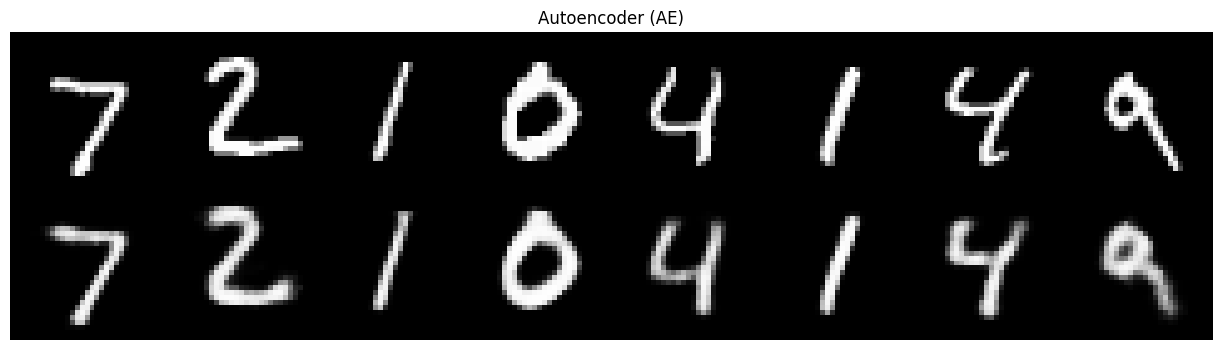

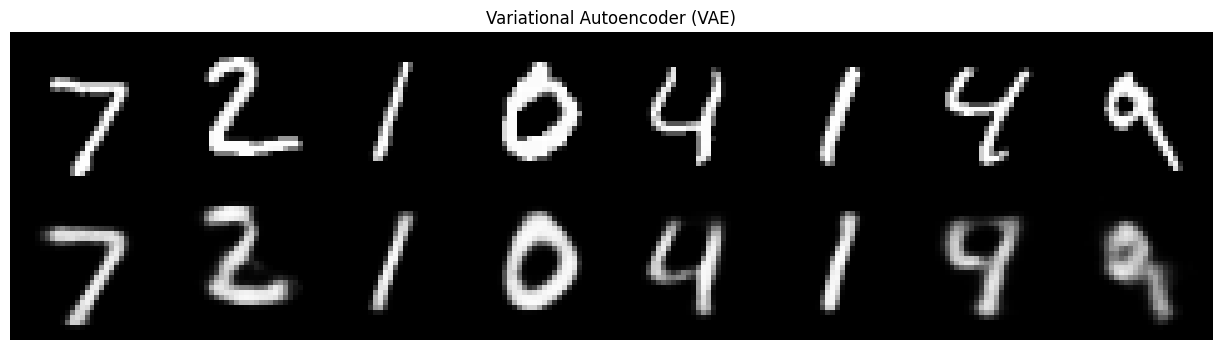

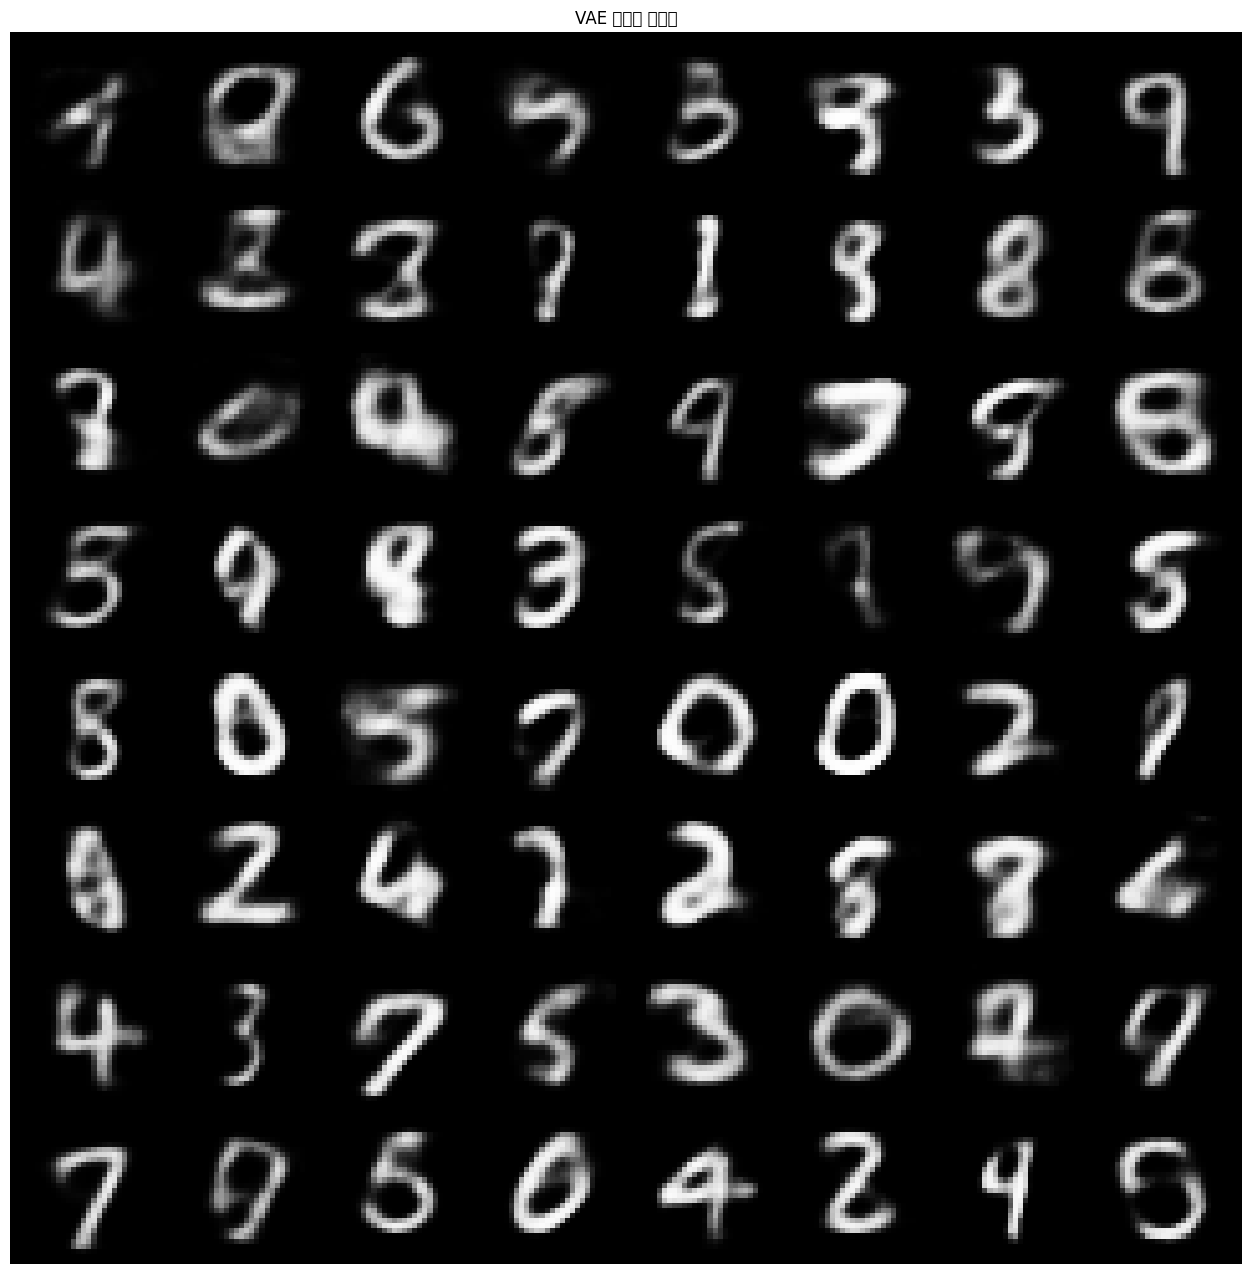